In [22]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import path
import matplotlib.patches as patches
from skimage import draw
import scipy.ndimage as ndimage
import Utils
import georasters as gr
import cv2
from Utils import doubleMADsfromMedian
from skimage.transform import resize
import pickle
import os
from fpdf import FPDF
import datetime


def create_indvPage(pdf, folder_img, GR_RGB, GR_T, GR_PV, string, panel, PLANTA, ZONA_PV):
    
    path_img = folder_img + str(ZONA_PV) + '_' + str(string['id']) + '_' + str(panel['id'])
    path = [path_img + '_IR.png',path_img +'_RGB.png', 
            path_img + '_mesa_IR.png', path_img +'_mesa_RGB.png',
            folder_img + str(ZONA_PV) + '_' + str(string['id']) + '_mesa_PV.png']
    
    if not(all([os.path.isfile(p) for p in path])):
        create_indvImg(path_img, GR_RGB, GR_T, GR_PV, string, panel)
    
    datetime_object = datetime.date.today() 
    
    
    pdf.add_page()
    pdf.set_font('Arial', 'B', 16)

    pdf.image('rentadrone-logo.png', x = 10, y = 10, w = 60, h = 10)
    pdf.cell(220, 10, '')
    pdf.set_font('Arial', '', 12)
    pdf.cell(40, 10, 'Fecha: ' + str(datetime_object))

    pdf.ln(10)

    pdf.cell(80, 10, 'Foto IR',0,0,  '') 
    pdf.cell(100, 10, 'Foto RGB',0,0,  '')
    pdf.cell(120, 10, 'Sector ' + ZONA_PV,0,0, 'C')

    ### Put image ####
    pdf.image(path_img + '_IR.png', x = 10, y = 30, w = 60, h = 30)
    pdf.image(path_img +'_RGB.png', x = 90, y = 30, w = 60, h = 30)
    pdf.ln(40)
    ### Put image ####
    pdf.cell(200, 10, 'ID Mesa Foto RGB',0,0,  '')
    ### Put image ####
    pdf.image(path_img +'_mesa_RGB.png', x = 10, y = 70, w = 190, h = 30)
    pdf.ln(40)
    ### Put image ####
    pdf.cell(200, 10, 'ID Mesa Foto Térmica Del mosaico',0,0,  '')
    ### Put image ####
    pdf.image(path_img + '_mesa_IR.png', x = 10, y = 110, w = 190, h = 30)
    pdf.ln(40)
    ### Put image ####
    ## Put image ###
    pdf.image(folder_img + str(ZONA_PV) + '_' + str(string['id']) + '_mesa_PV.png', x= 200, y =30, w = 110, h = 160)
    ## Put image ###

    pdf.cell(0, 10, 'Datos de la falla:')
    pdf.ln(10)
    pdf.cell(75, 10, 'Planta: ' + PLANTA)
    pdf.cell(40, 10, 'ZONA PV: ' + ZONA_PV)

    pdf.ln(10)
    pdf.cell(75, 10, 'ID PANEL: ' + str(string['id']) + '_' + str(panel['id']))
    pdf.cell(60, 10, 'Tipo: '+ panel['status'])
    pdf.cell(40, 10, 'Severidad: ' + panel['severidad'])


def create_indvImg(path_img, GR_RGB, GR_T, GR_PV, string, panel, epsilon = 20, dpi = 100):
    
    geot_T = GR_T.geot
    geot_RGB = GR_RGB.geot
    geot_PV = GR_PV.geot
    
    matrix_expand_bounds = [[-epsilon, -epsilon],
                            [+epsilon, -epsilon], 
                            [+epsilon, +epsilon], 
                            [-epsilon, +epsilon]]
    
    
    ############ Image IR ############
    Points = Utils.gps2pixel(panel['points'], geot_T) + matrix_expand_bounds
    plt.figure(0)
    plt.figure(figsize=(8, 8))
    plt.imsave(path_img +'_IR.png',GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]],
               cmap = 'gray', dpi=dpi)

    ############ Image RGB ############
    Points = Utils.gps2pixel(panel['points'], geot_RGB) + matrix_expand_bounds
    plt.figure(1)
    plt.figure(figsize=(8, 8))
    plt.imsave(path_img + '_RGB.png',GR_RGB.raster.data[:3,:,:].transpose(1, 2, 0)[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0],:],
               dpi=dpi)


    ############ Image IR mesa ############
    Points = Utils.gps2pixel(string['points'], geot_T) + matrix_expand_bounds
    plt.figure(2)
    plt.figure(figsize=(16, 16))

    ax = plt.axes(frameon=False, xticks=[],yticks=[])
    ax.imshow(GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]])


    Points = Utils.gps2pixel(panel['points'], geot_T) -  (Points[0][0], Points[0][1])
    poly = patches.Polygon(Points,
                     linewidth=2,
                     edgecolor='red',
                     alpha=.5,
                     fill = False)

    ax.add_patch(poly)

    plt.savefig(path_img + '_mesa_IR.png', bbox_inches='tight', pad_inches=0, dpi = dpi)
    plt.close()

    ############ Image RGB mesa ############

    Points = Utils.gps2pixel(string['points'], geot_RGB) + matrix_expand_bounds
    plt.figure(3)
    plt.figure(figsize=(16, 16))

    ax = plt.axes(frameon=False, xticks=[],yticks=[])
    ax.imshow(GR_RGB.raster.data[:3,:,:].transpose(1, 2, 0)[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0],:])

    Points = Utils.gps2pixel(panel['points'], geot_RGB) - (Points[0][0], Points[0][1])

    poly = patches.Polygon(Points,
                     linewidth=2,
                     edgecolor='red',
                     alpha=.5,
                     fill = False)

    ax.add_patch(poly)

    plt.savefig(path_img + '_mesa_RGB.png', bbox_inches='tight', pad_inches=0, dpi = dpi)    
    plt.close()   


    plt.figure(4)
    plt.figure(figsize=(16, 16))

    ax = plt.axes(frameon=False, xticks=[],yticks=[])
    A = GR_PV.raster.data
    A[0,0] = 2
    ax.imshow(-A,cmap = 'gray')

    Points = Utils.gps2pixel(string['points'], geot_PV)
    poly = patches.Polygon(Points,
                     linewidth=2,
                     edgecolor='red',
                     alpha=1,
                     fill = True,
                     color = 'red')
    plt.text(np.mean([x[0]  for x in Points]), np.mean([y[1]  for y in Points]) , str(string['id']),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)

    plt.savefig('_'.join(path_img.split('_')[:-1]) +'_mesa_PV.png', bbox_inches='tight', pad_inches=0, dpi = dpi)

    #I =  cv2.rotate(cv2.imread('im_mesa_PV.png'), cv2.ROTATE_90_COUNTERCLOCKWISE)
    #cv2.imwrite('im_mesa_PV.png', I)
    plt.close()
    
    
    
def create_multiPage(pdf, folder_img, GR_RGB, GR_T, GR_PV, string, panels, PLANTA, ZONA_PV):
    
    path_img = folder_img + str(ZONA_PV) + '_' + str(string['id'])
    path = [path_img + '_mesa_RGB_multi.png', path_img +'_mesa_IR_multi.png',
            folder_img + str(ZONA_PV) + '_' + str(string['id']) + '_mesa_PV.png']
    
    if not(all([os.path.isfile(p) for p in path])):
        create_multiImg(path_img, GR_RGB, GR_T, GR_PV, string, panels)
    
    datetime_object = datetime.date.today() 
    
    pdf.add_page()
    pdf.set_font('Arial', 'B', 16)

    pdf.image('rentadrone-logo.png', x = 10, y = 10, w = 60, h = 10)
    pdf.cell(220, 10, '')
    pdf.set_font('Arial', '', 12)
    pdf.cell(40, 10, 'Fecha: ' + str(datetime_object))

    pdf.ln(10)

    pdf.cell(180, 10, 'ID Mesa Foto RGB',0,0,  '')
    pdf.cell(120, 10, 'Sector ' + ZONA_PV,0,0, 'C')



    ### Put image ####
    pdf.image(path_img +'_mesa_RGB_multi.png', x = 10, y = 30, w = 190, h = 30)
    pdf.ln(40)
    ### Put image ####
    pdf.cell(200, 10, 'ID Mesa Foto Térmica Del mosaico',0,0,  '')
    ### Put image ####
    pdf.image(path_img + '_mesa_IR_multi.png', x = 10, y = 70, w = 190, h = 30)
    pdf.ln(40)
    ### Put image ####
    ## Put image ###
    pdf.image(path_img + '_mesa_PV.png', x= 200, y =30, w = 110, h = 160)
    ## Put image ###

    pdf.cell(0, 10, 'Datos de la falla:')
    pdf.ln(10)
    pdf.cell(75, 10, 'Planta: ' + PLANTA)
    pdf.cell(40, 10, 'ZONA PV: ' + ZONA_PV)
    pdf.ln(10)
    pdf.cell(60, 10, 'Tipo: '+ list(panels.items())[0][1]['status'])
    pdf.cell(40, 10, 'Severidad: ' + list(panels.items())[0][1]['severidad'])
    pdf.ln(10)
    pdf.multi_cell(150, 10, 'ID PANEL: ' + ', '.join([str(string['id']) + '_' + str(key) for key in panels.keys()]))
    
def create_multiImg(path_img, GR_RGB, GR_T, GR_PV, string, panels, epsilon = 20, dpi = 100):
    
    geot_T = GR_T.geot
    geot_RGB = GR_RGB.geot
    geot_PV = GR_PV.geot
    
    matrix_expand_bounds = [[-epsilon, -epsilon],
                            [+epsilon, -epsilon], 
                            [+epsilon, +epsilon], 
                            [-epsilon, +epsilon]]
    

    ############ Image IR mesa ############
    Points = Utils.gps2pixel(string['points'], geot_T) + matrix_expand_bounds
    plt.figure(2)
    plt.figure(figsize=(16, 16))

    ax = plt.axes(frameon=False, xticks=[],yticks=[])
    ax.imshow(GR_T.raster.data[0,Points[0][1] : Points[2][1], Points[0][0]: Points[2][0]])

    for panel_key in panels.keys():
        
        panel = panels[panel_key]
        Points = Utils.gps2pixel(panel['points'], geot_T) -  (Points[0][0], Points[0][1])
        poly = patches.Polygon(Points,
                         linewidth=2,
                         edgecolor='red',
                         alpha=.5,
                         fill = False)

        ax.add_patch(poly)

    plt.savefig(path_img + '_mesa_IR_multi.png', bbox_inches='tight', pad_inches=0, dpi = dpi)
    plt.close()

    ############ Image RGB mesa ############

    Points = Utils.gps2pixel(string['points'], geot_RGB) + matrix_expand_bounds
    plt.figure(3)
    plt.figure(figsize=(16, 16))

    ax = plt.axes(frameon=False, xticks=[],yticks=[])
    ax.imshow(GR_RGB.raster.data[:3,:,:].transpose(1, 2, 0)[Points[0][1] : Points[2][1], Points[0][0]: Points[2][0],:])
    
    for panel_key in panels.keys():
        
        panel = panels[panel_key]
        Points = Utils.gps2pixel(panel['points'], geot_RGB) - (Points[0][0], Points[0][1])

        poly = patches.Polygon(Points,
                         linewidth=2,
                         edgecolor='red',
                         alpha=.5,
                         fill = False)

        ax.add_patch(poly)

    plt.savefig(path_img + '_mesa_RGB_multi.png', bbox_inches='tight', pad_inches=0, dpi = dpi)    
    plt.close()   


    plt.figure(4)
    plt.figure(figsize=(16, 16))

    ax = plt.axes(frameon=False, xticks=[],yticks=[])
    A = GR_PV.raster.data
    A[0,0] = 2
    ax.imshow(-A,cmap = 'gray')

    Points = Utils.gps2pixel(string['points'], geot_PV)
    poly = patches.Polygon(Points,
                     linewidth=2,
                     edgecolor='red',
                     alpha=1,
                     fill = True,
                     color = 'red')
    plt.text(np.mean([x[0]  for x in Points]), np.mean([y[1]  for y in Points]) , str(string['id']),  bbox=dict(facecolor='red', alpha=0.8))

    ax.add_patch(poly)

    plt.savefig(path_img +'_mesa_PV.png', bbox_inches='tight', pad_inches=0, dpi = dpi)

    #I =  cv2.rotate(cv2.imread('im_mesa_PV.png'), cv2.ROTATE_90_COUNTERCLOCKWISE)
    #cv2.imwrite('im_mesa_PV.png', I)
    plt.close()

In [13]:
path_folder = "El_Aguila_2020/"
folder_img = "El_Aguila_2020/img/"
path_T = "El_Aguila_2020/Thermo.tif"
path_RGB = "El_Aguila_2020/RGB.tif"
path_PV = "El_Aguila_2020/Thermo_String_PV01.tif"
path_save_list = "El_Aguila_2020/List_strings_panels_PV01.txt"
path_save_list_print = "El_Aguila_2020/List_strings_panels_print_PV01.txt"
PLANTA  = 'El Aguila'
ZONA_PV = 'PV01'
pdf_name = 'Informe PV01.pdf'

GR_T = gr.from_file(path_T)
GR_RGB = gr.from_file(path_RGB)
GR_PV = gr.from_file(path_PV)

## Load List in coordinate latitud and longitude  to pixels ###
with open(path_save_list, "rb") as fp:
    L_strings_coord_load = pickle.load(fp)


In [14]:
List_panel_affected_indv = {}
List_panel_affected_multi = {}
for string_key in L_strings_coord_load.keys():
    string = L_strings_coord_load[string_key]
    List_panel_affected_indv[string_key] = string.copy()
    List_panel_affected_indv[string_key]['panels'] = {}
    List_panel_affected_multi[string_key] = string.copy()
    List_panel_affected_multi[string_key]['panels'] = {}
    for panel_key in string['panels'].keys():
        panel = string['panels'][panel_key]
        if panel['status'] != 'default':
            if panel['status'] == '5.Panel Desconect' or panel['status'] == '8.Tracker dañado':
                List_panel_affected_multi[string_key]['panels'][panel_key] =  panel
            else:
                List_panel_affected_indv[string_key]['panels'][panel_key] =  panel
            
for string_key in list(List_panel_affected_indv.keys()):
    string = List_panel_affected_indv[string_key]
    if string['panels'] == {}:
        del List_panel_affected_indv[string_key]

for string_key in list(List_panel_affected_multi.keys()):
    string = List_panel_affected_multi[string_key]
    if string['panels'] == {}:
        del List_panel_affected_multi[string_key]

In [27]:
pdf = FPDF('L', 'mm', 'A4')

for string_key in List_panel_affected_indv.keys():
    
    string = List_panel_affected_indv[string_key]
    
    for panel_key in string['panels'].keys():
        
        panel = string['panels'][panel_key]
        create_indvPage(pdf, folder_img, GR_RGB, GR_T, GR_PV, string, panel, PLANTA, ZONA_PV)

for string_key in List_panel_affected_multi.keys():
    
    string = List_panel_affected_multi[string_key]
    aux = [{panel_key: string['panels'][panel_key]  for panel_key in string['panels'].keys() if string['panels'][panel_key]['status'] == '5.Panel Desconect'}, 
           {panel_key: string['panels'][panel_key]  for panel_key in string['panels'].keys() if string['panels'][panel_key]['status'] == '8.Tracker dañado'}] 
    
    for panels in aux:
        
        if panels != {}:
            create_multiPage(pdf, folder_img, GR_RGB, GR_T, GR_PV, string, panels, PLANTA, ZONA_PV)
        
pdf.output(pdf_name, 'F')

''

''

{'id': 51,
 'points': array([[-69.88693964, -18.44558698],
        [-69.88692081, -18.44558698],
        [-69.88692081, -18.4455967 ],
        [-69.88693964, -18.4455967 ]]),
 'status': '4.Falla diodo(s)',
 'prob': 0.0,
 'T': 26.106624271330155,
 'severidad': 'High'}

'Media'

'16_1, 16_2, 16_3, 16_4, 16_5, 16_6, 16_7, 16_8, 16_9, 16_10, 16_11, 16_12, 16_13, 16_14, 16_15, 16_16, 16_17, 16_18, 16_19, 16_20'

/home/dlsaavedra/anaconda3/envs/new/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


<Figure size 432x288 with 0 Axes>

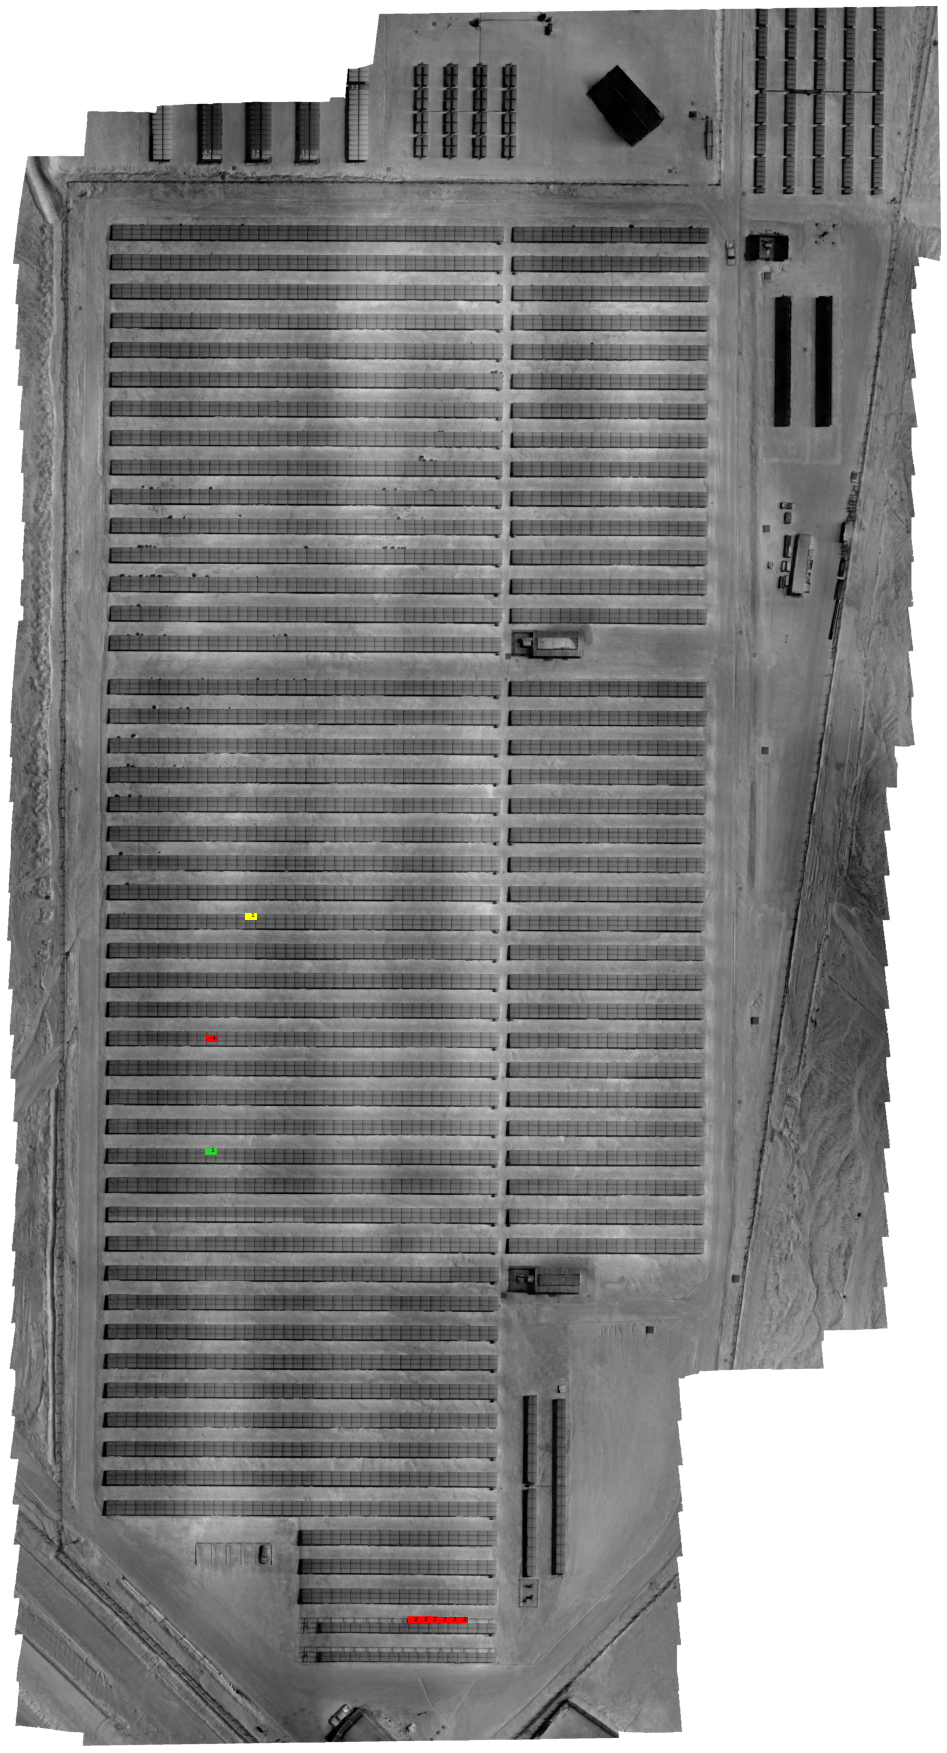

In [56]:
        
plt.figure(4)
plt.figure(figsize=(32, 32))
ax = plt.axes(frameon=False, xticks=[],yticks=[])

ax.imshow(GR_T.raster.data[0, :, :],cmap = 'gray')

#ax.imshow(GR_RGB.raster.data[:3,:,:].transpose(1, 2, 0))
color_dict = {'High': 'red', 'Media' : 'yellow', 'Low' : 'limegreen'}

for string_key in List_panel_affected_indv.keys():
    
    string = List_panel_affected_indv[string_key]
    
    for panel_key in string['panels'].keys():
        
        panel = string['panels'][panel_key]

        Points = Utils.gps2pixel(panel['points'], GR_T.geot)
        poly = patches.Polygon(Points,
                         linewidth=2,
                         edgecolor=color_dict[panel['severidad']],
                         alpha=1,
                         fill = True,
                         color = color_dict[panel['severidad']])
        plt.text(np.mean([x[0]  for x in Points]), np.mean([y[1]  for y in Points]) , str(panel['status'].split('.')[0]),  
                 bbox=dict(facecolor='red', alpha=0), fontsize=6)

        ax.add_patch(poly)

'2'

In [77]:
epsilon = 1
matrix_expand_bounds = [[-epsilon, -epsilon],[+epsilon, -epsilon], [+epsilon, +epsilon], [-epsilon, +epsilon]]
t_min = np.min(GR_T.raster.data)
t_max = np.max(GR_T.raster.data)
t_new_min = 0
t_new_max = 70

geot = GR_T.geot

panel = L_strings_coord_load['54']['panels']['51']
Points =  Utils.gps2pixel(panel['points'], geot) + matrix_expand_bounds
t_new_min + (t_new_max - t_new_min) * np.mean(GR_T.raster.data[0,Points[0][1]-epsilon : Points[2][1] + epsilon, Points[0][0]- epsilon: Points[2][0] + epsilon]) / (t_max - t_min)


24.76920930974016

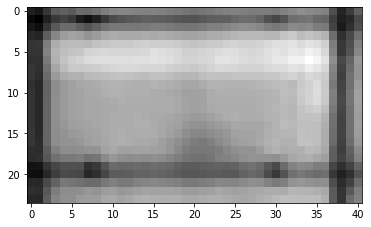

In [75]:
plt.imshow(GR_T.raster.data[0,Points[0][1]-epsilon : Points[2][1] + epsilon, Points[0][0]- epsilon: Points[2][0] + epsilon], cmap = 'gray')